In [1]:
!nvidia-smi

Fri Apr 14 04:42:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00


In [4]:
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
ROOT = "/content/drive/MyDrive/Colab Notebooks/AI_PROJECT/INDIAN BIRDS"

In [9]:
data_dir = ROOT
train_dir = "/content/drive/MyDrive/Colab Notebooks/AI_PROJECT/INDIAN BIRDS/Train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/AI_PROJECT/INDIAN BIRDS/Test"

In [48]:
train_data = datasets.ImageFolder(root = train_dir, transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.5049, 0.5125, 0.4293])
Calculated stds: tensor([0.1643, 0.1629, 0.1741])


In [11]:
pretrained_size = 224
pretrained_means = [0.4909, 0.5135, 0.4679]
pretrained_stds= [0.1804, 0.1800, 0.1916]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [12]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [13]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [14]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [15]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 12401
Number of validation examples: 1378
Number of testing examples: 150


In [16]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [17]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [18]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

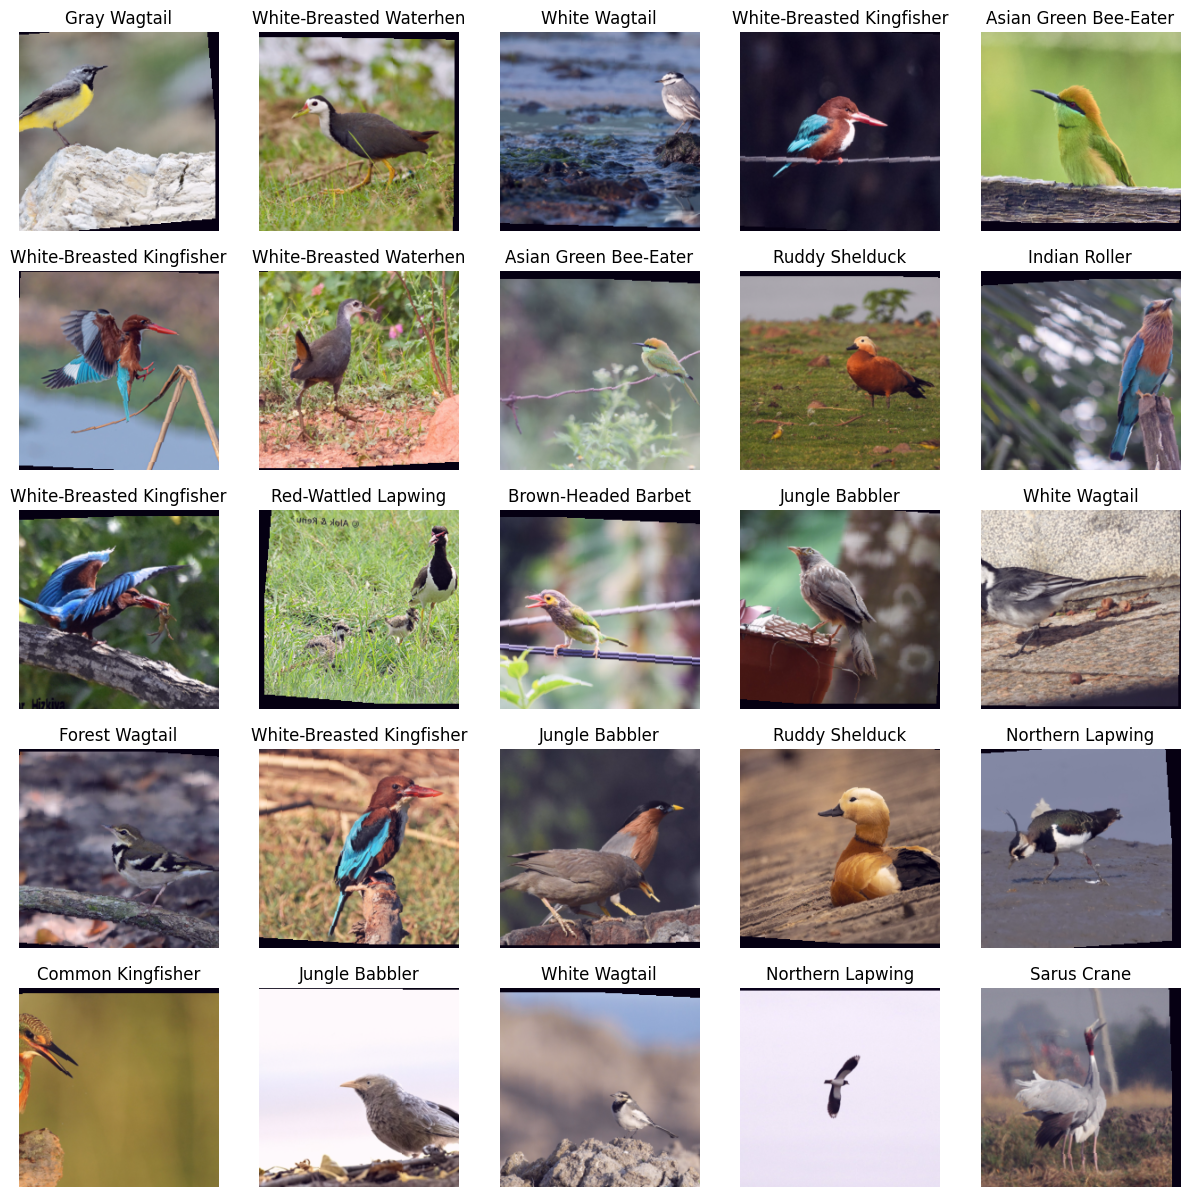

In [19]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [20]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

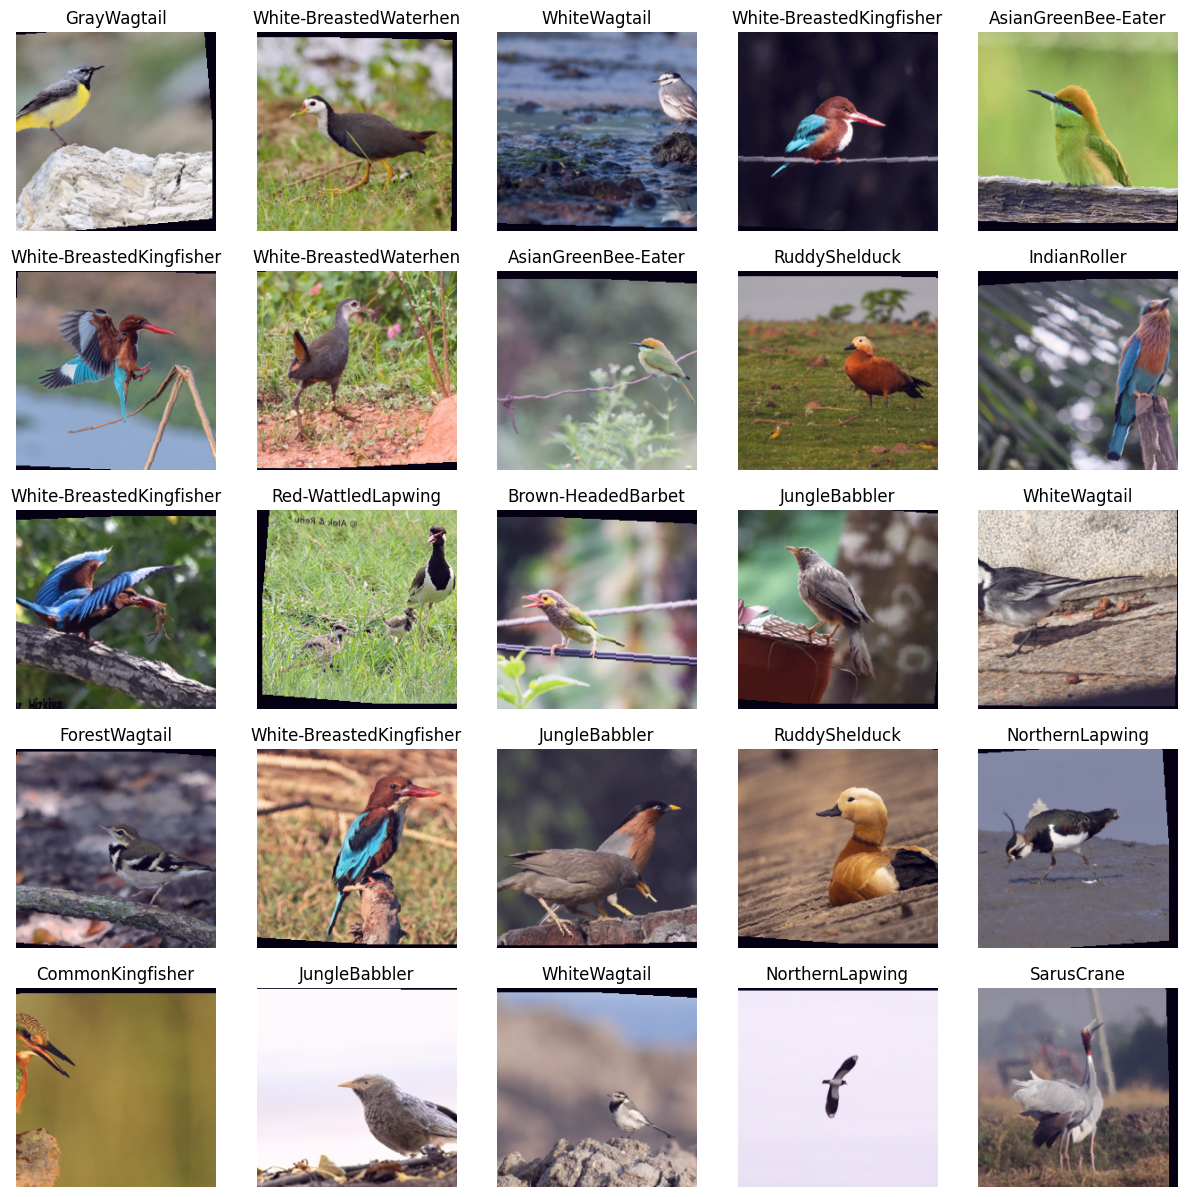

In [21]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

In [22]:
num_classes = 15

In [23]:
import torchvision.models as models

# Load the pre-trained MobileNet model
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [24]:
# Get the number of trainable parameters in the model
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {trainable_params:,} trainable parameters')

The model has 3,504,872 trainable parameters


In [25]:
import os
import torch

# Create a new directory
save_dir = "/RiddhiBhuva/AI_Project/Mobilenet_Datasets"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [26]:
# Save the state dictionary of the Mobilenet model
torch.save(model.state_dict(), os.path.join(save_dir, 'mobilenet2.pth'))

In [27]:
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [30]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=9d85440dbd60c5a019f55471e30d991931666de24af8488425ba8956b2d92c84
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [31]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [32]:
run_name = 'Mobilenet-Dataset2' 
wandb.init(project="AIProject2023", name = run_name, reinit=True)

wandb: Currently logged in as: riddhivinodbhuva (riddhibhuva). Use `wandb login --relogin` to force relogin


In [33]:
import time

train_losses = []
train_acc_list = []
valid_losses = []
valid_acc_list = []

num_epochs = 10
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    # Training loop
    model.train()
    for images, labels in train_iterator:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        wandb.log({'train_loss': loss.item()})
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in valid_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            wandb.log({'valid_loss': loss.item()})
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()
            valid_total += labels.size(0)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), run_name)

    # Calculate metrics
    train_loss = train_loss / len(train_iterator.dataset)
    valid_loss = valid_loss / len(valid_iterator.dataset)
    train_accuracy = 100 * train_correct / train_total
    valid_accuracy = 100 * valid_correct / valid_total
    

    wandb.log({'train_accuracy': train_accuracy})
    wandb.log({'valid_accuracy': valid_accuracy})
    
    #append values
    train_losses.append(train_loss)
    train_acc_list.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_acc_list.append(valid_accuracy)
   
    
    # Print metrics
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} took {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {valid_loss:.6f} | Val Accuracy: {valid_accuracy:.2f}%")

Epoch 1 took 51m 12s
Train Loss: 3.477019 | Train Accuracy: 11.27%
Val Loss: 2.607774 | Val Accuracy: 14.30%
Epoch 2 took 8m 28s
Train Loss: 2.508918 | Train Accuracy: 17.93%
Val Loss: 2.445757 | Val Accuracy: 20.10%
Epoch 3 took 8m 15s
Train Loss: 2.382525 | Train Accuracy: 21.66%
Val Loss: 2.331042 | Val Accuracy: 23.51%
Epoch 4 took 8m 30s
Train Loss: 2.282859 | Train Accuracy: 24.68%
Val Loss: 2.233491 | Val Accuracy: 26.34%
Epoch 5 took 8m 20s
Train Loss: 2.203504 | Train Accuracy: 27.57%
Val Loss: 2.138461 | Val Accuracy: 29.90%
Epoch 6 took 8m 21s
Train Loss: 2.126600 | Train Accuracy: 29.76%
Val Loss: 2.049791 | Val Accuracy: 33.16%
Epoch 7 took 8m 16s
Train Loss: 2.041113 | Train Accuracy: 32.66%
Val Loss: 1.987436 | Val Accuracy: 35.05%
Epoch 8 took 8m 17s
Train Loss: 1.968805 | Train Accuracy: 34.98%
Val Loss: 1.899621 | Val Accuracy: 36.21%
Epoch 9 took 8m 13s
Train Loss: 1.896050 | Train Accuracy: 37.47%
Val Loss: 1.831765 | Val Accuracy: 38.39%
Epoch 10 took 8m 14s
Train 

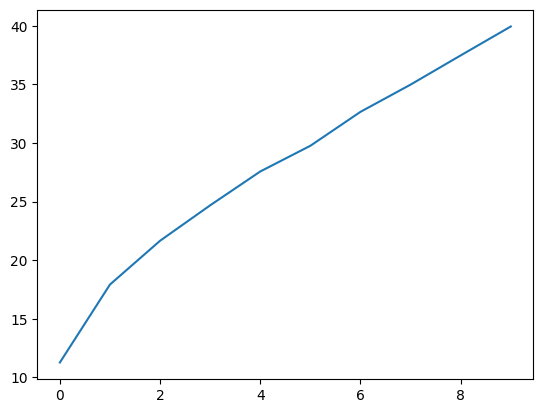

In [34]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_list)), train_acc_list)

In [35]:
# Testing loop
model.eval()
with torch.no_grad():
    total_test_loss = 0
    total_test_accuracy = 0
    total_test_count = 0
    for images, labels in test_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test_accuracy += (predicted == labels).sum().item()
        total_test_count += images.size(0)

    average_test_loss = total_test_loss / total_test_count
    average_test_accuracy = total_test_accuracy / total_test_count

print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy:.4f}")


Test Loss: 1.7715, Test Accuracy: 0.4067


In [36]:
# Evaluation loop
model.eval()
with torch.no_grad():
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_count = 0
    for images, labels in valid_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_val_accuracy += (predicted == labels).sum().item()
        total_val_count += images.size(0)

    average_val_loss = total_val_loss / total_val_count
    average_val_accuracy = total_val_accuracy / total_val_count

print(f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")


Validation Loss: 1.7732, Validation Accuracy: 0.4042


In [37]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

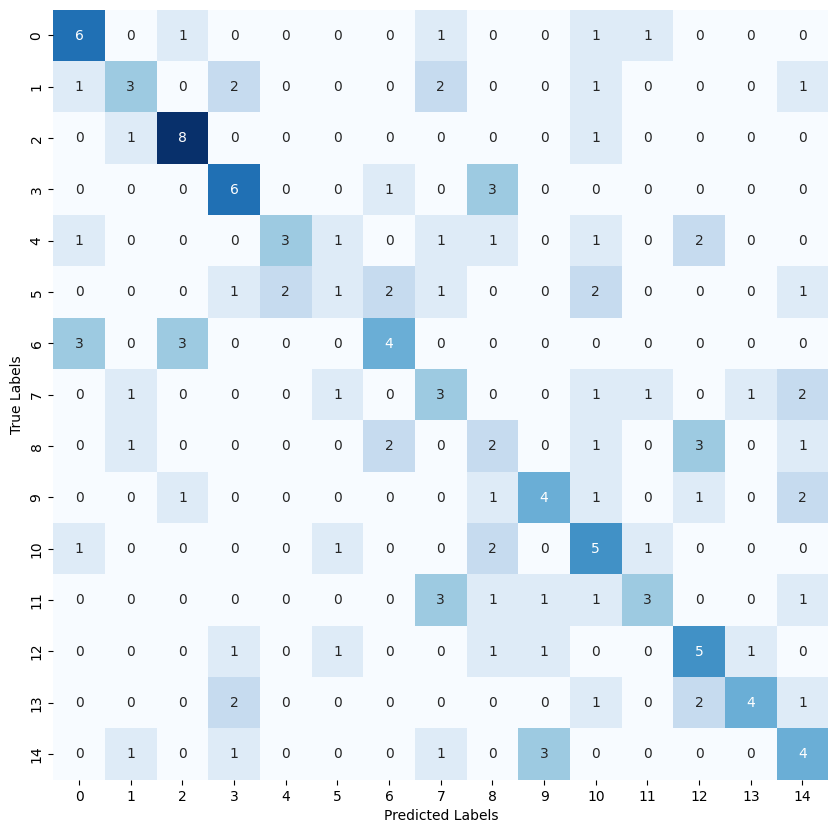

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
images, labels, probs = get_predictions(model, test_iterator)

# Get predicted labels
pred_labels = torch.argmax(probs, 1)

# Create confusion matrix
conf_mat = confusion_matrix(labels.view(-1), pred_labels.view(-1))

# Plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [39]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred_labels, target_names=classes))

                          precision    recall  f1-score   support

     AsianGreenBee-Eater       0.50      0.60      0.55        10
      Brown-HeadedBarbet       0.43      0.30      0.35        10
        CommonKingfisher       0.62      0.80      0.70        10
              CommonMyna       0.46      0.60      0.52        10
           ForestWagtail       0.60      0.30      0.40        10
             GrayWagtail       0.20      0.10      0.13        10
            IndianRoller       0.44      0.40      0.42        10
           JungleBabbler       0.25      0.30      0.27        10
         NorthernLapwing       0.18      0.20      0.19        10
      Red-WattledLapwing       0.44      0.40      0.42        10
           RuddyShelduck       0.31      0.50      0.38        10
              SarusCrane       0.50      0.30      0.37        10
            WhiteWagtail       0.38      0.50      0.43        10
White-BreastedKingfisher       0.67      0.40      0.50        10
  White-B

In [40]:
from sklearn.decomposition import PCA

In [41]:
# Define a function to extract features from a given layer of the model
def extract_features(model, layer, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            outputs = model(images)
            features.append(outputs.detach().numpy())
    features = np.vstack(features)
    return features

In [42]:
# Define the layer to extract features from
layer = model.classifier[1]

In [43]:
# Set the device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [44]:
model = model.cpu()

In [45]:
# Extract the features from the last layer of the model
features = extract_features(model, layer, test_iterator)

# Perform PCA on the features
n_components = 2  # number of principal components to keep
pca = PCA(n_components)
pca_weights = pca.fit_transform(features)

# Print the explained variance of each principal component
print(pca.explained_variance_ratio_)
     

[0.96107185 0.01432549]


In [46]:
test_labels = []
for images, labels in test_iterator:
    # append the labels to the test_labels list
    test_labels.extend(labels.numpy())

# Convert the test_labels to a numpy array
test_labels = np.array(test_labels)

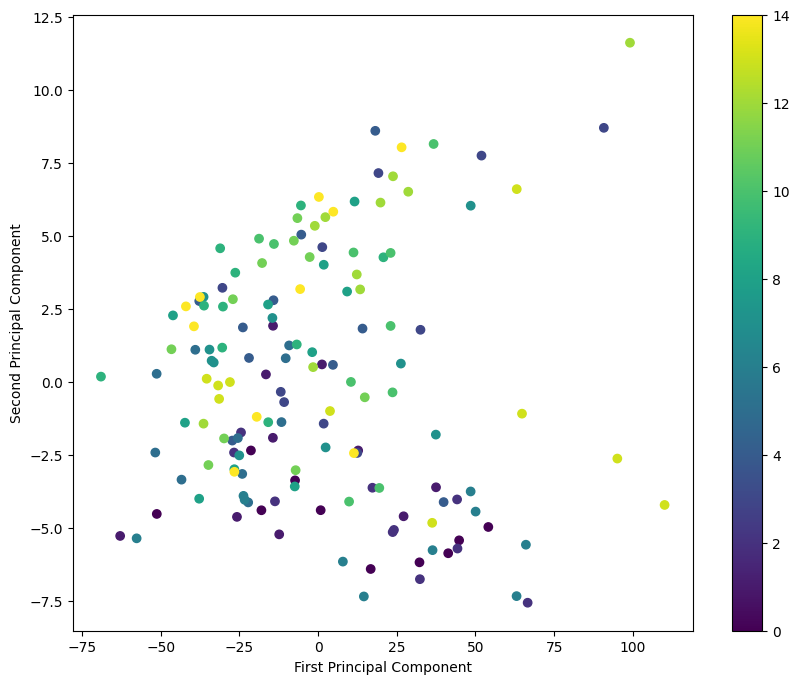

In [47]:
import matplotlib.pyplot as plt

# Plot the PCA graph
plt.figure(figsize=(10, 8))
plt.scatter(pca_weights[:, 0], pca_weights[:, 1], c=test_labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()
